In [74]:
from pykat import finesse 
       
from pykat.commands import *     
import numpy as np               
import matplotlib.pyplot as plt  
import scipy                     
from IPython import display
from scipy.signal import find_peaks 

              

pykat.init_pykat_plotting(dpi=200)

kat=finesse.kat()
kat.verbose=1


In [75]:
kat.parse("""

l laser 30 0 n1                          #laser 30W
maxtem 3
s gap01 1 n1 n2                         #space b/w mod and laser  
mod eom1 $sb1 0.18 3 pm n2 n3         #modulator PM $sb1 3f
s gap02 0.5 n3 n31a                     #space b/w mod and PRM      


##### FOR ANGULAR SENSING PRM #####
bs pickoff 0.0001 0.9999 0 45 n31a dump n32 refl_a
s s2 0.1 refl_a a8                       
bs bsQPD 0.5 0.5 0 45 a8 a9 a10 dump            #bs to split power between two detectors 

s sQPD1 0.1 a9 a11                   
s sQPD2 0.1 a10 a12
#########################



##### FOR ANGULAR SENSING ITM/ETM #####
s sr 0.01 bs12tr n12a    
bs pickoff1 0.0001 0.9999 0 45 n12a dump n121 refl_itm
s s21 0.1 refl_itm a81                       
bs bsQPD1 0.5 0.5 0 45 a81 a91 a101 dump            #bs to split power between two detectors 

s sQPD11 0.1 a91 a11a                   
s sQPD21 0.1 a101 a12a
#########################



####### 3 m setup ###########

s gap03 0.5 n32 refl

m PRM 0.899 0.1 0 refl pop               #PRM                ---> POP <---

##### folding mirrors #####
s prc 0.5 pop bs1a
bs bs1 0.999 0.001 0 0 bs1a bs12 bs12tr dump
s b1 0.350 bs12 bs21
bs bs2 0.999 0.001 0 0 bs21 bs21a bs21tr dump
s b2 0.5 bs21a b3    
###########################

#m PRM 0 1 90 refl pop               #PRM
#s PRC 1.33 pop b3                        #PRC 
m ITM 0.98997 0.01 0 b3 n12              #ITM
s ARM 3.3 n12 b5                        #ARM length 3.3 (0.01 from sr length) 
m ETM 0.99996 0.00001 0 b5 b6           #ETM
#m ETM 0 1 0 b5 b6 

################################


cav ARML ITM n12 ETM b5 
cav PRCL PRM pop ITM b3


##### attr for TM ######
attr ETM Rc 11.3            # RoC of ETM
attr PRM Rc -23.6           # RoC of PRM
attr PRM xbeta 0            # misalgnment PRM
attr ETM xbeta 0            # misalgnment ETM
attr ITM xbeta 0            # misalgnment ITM
######################


trace 2 
phase 2

const sb1 55.556M
const sb2 111.112M
const sb3 166.668M


""")


In [76]:
#### DC PDs ##########

kat_dc = kat.deepcopy()
kat_dc.parse("""

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6


xaxis PRM phi lin -10 140 80000


""")

--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:27:24.989947


100% | ETA:  0:00:00 | Saving data                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 85.595 seconds

--- Output info ---

Run date and time: 2022-11-17 23:27:24.990443
Detectors used: circ_arm, circ_prc, refl, trans

One xaxis used: ['xaxis PRM phi lin -10 140 80000']
circ_arm : min = 3.096688503409610e+02 max = 2.583401090408810e+05
circ_prc : min = 8.137725938592220e-01 max = 6.763211759306820e+02
refl     : min = 8.539145707203319e+00 max = 2.994124991769230e+01
trans    : min = 3.096812375904650e-03 max = 2.583504430586030e+00


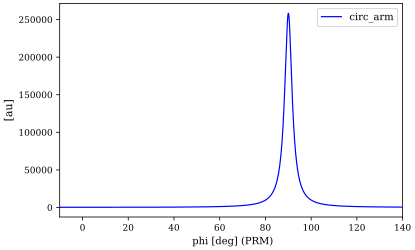

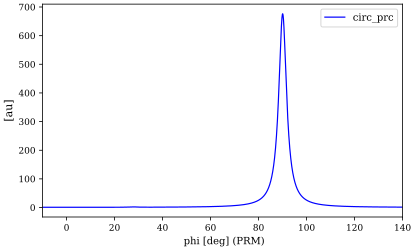

max power arm 258340.109040881
array number [[53350]]
PRM tuning for max power in arm and prc [[90.03125]]


In [77]:
### Tuning check ####

out_dc = kat_dc.run()
out_dc.info()
out_dc.plot(['circ_arm'])
out_dc.plot(['circ_prc'])
print("max power arm",max(out_dc['circ_arm']))
print("array number",np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm'])))
print("PRM tuning for max power in arm and prc",out_dc.x[np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm']))])


### SET PRM phi ###
kat.PRM.phi = out_dc.x[np.argwhere(out_dc['circ_arm'] == max(out_dc['circ_arm']))]


In [78]:
#### POP & REFL RF PDs #####

kat_pd1s = kat.deepcopy()
kat_pd1s.parse(""" 


const sb1 55.556M
const sb2 111.112M
const sb3 166.668M 

pd2 pop_I $sb1 60 10 0 bs21tr                # POP I  1f
pd2 pop_Q $sb1 70 10 0 bs21tr               # POP Q  1f
pd2 pop_I_f2 $sb2 0 10 0 bs21tr            # POP I  3f
pd2 pop_Q_f2 $sb2 90 10 0 bs21tr           # POP Q  3f
pd2 pop_I_f3 $sb3 0 10 0 bs21tr            # POP I  3f
pd2 pop_Q_f3 $sb3 90 10 0 bs21tr           # POP Q  3f


pd2 refl_I $sb1 0 10 0 refl              # REFL I  1f
pd2 refl_Q $sb1 90 10 0 refl             # REFL Q  1f
pd2 refl_I_f2 $sb2 0 10 0 refl          # REFL I  3f
pd2 refl_Q_f2 $sb2 90 10 0 refl         # REFL Q  3f
pd2 refl_I_f3 $sb3 0 10 0 refl          # REFL I  3f
pd2 refl_Q_f3 $sb3 90 10 0 refl         # REFL Q  3f

#set refl_Q_new refl_Q re
#set refl_I_new refl_I re 
#set refl_I_f2_new refl_I_f2 re
#set refl_Q_f2_new refl_Q_f2 re
#
#set pop_Q_new pop_Q re
#set pop_I_new pop_I re 
#set pop_I_f2_new pop_I_f2 re
#set pop_Q_f2_new pop_Q_f2 re
#
#
#func refl_I_sb3f = $refl_I_new + $refl_I_f2_new
#func refl_Q_sb3f = $refl_Q_new + $refl_Q_f2_new
#func pop_I_sb3f = $pop_I_new + $pop_I_f2_new
#func pop_Q_sb3f = $pop_Q_new + $pop_Q_f2_new


pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6


#xaxis sig1 f log .01 100 8000

put refl_I f2 $x1
put refl_Q f2 $x1
put refl_I_f2 f2 $x1
put refl_Q_f2 f2 $x1
put refl_I_f3 f2 $x1
put refl_Q_f3 f2 $x1

put pop_I f2 $x1
put pop_Q f2 $x1
put pop_I_f2 f2 $x1
put pop_Q_f2 f2 $x1
put pop_I_f3 f2 $x1
put pop_Q_f3 f2 $x1



#scale deg

""")


Finesse variable `$x1` does not exist.


Parsing `put refl_I f2 $x1` into pykat object not implemented
yet, added as extra line.


Finesse variable `$x1` does not exist.


Parsing `put refl_Q f2 $x1` into pykat object not implemented
yet, added as extra line.


Finesse variable `$x1` does not exist.


Parsing `put refl_I_f2 f2 $x1` into pykat object not
implemented yet, added as extra line.


Finesse variable `$x1` does not exist.


Parsing `put refl_Q_f2 f2 $x1` into pykat object not
implemented yet, added as extra line.


Finesse variable `$x1` does not exist.


Parsing `put refl_I_f3 f2 $x1` into pykat object not
implemented yet, added as extra line.


Finesse variable `$x1` does not exist.


Parsing `put refl_Q_f3 f2 $x1` into pykat object not
implemented yet, added as extra line.


Finesse variable `$x1` does not exist.


Parsing `put pop_I f2 $x1` into pykat object not implemented
yet, added as extra line.


Finesse variable `$x1` does not exist.


Parsing `put pop_Q f2 $x1` int

In [79]:
#### decoupling method ####




In [80]:
ETM_tun = kat_pd1s.deepcopy()
ETM_tun.parse("""
fsig sig1 ETM 10 0
xaxis sig1 f log 1 800 800
""")
#out_etm = ETM_tun.run()
#out_etm.plot(['pop_I','pop_Q'])
#out_etm.plot(['pop_I_f3','pop_Q_f3'])
#out_etm.plot(['refl_I','refl_Q'])
#out_etm.plot(['refl_I_f3','refl_Q_f3'])
#out_etm.plot(['circ_arm'])
#out_etm.plot(['circ_prc'])
#out_etm.plot(['refl'])
#
PRM_tun = kat_pd1s.deepcopy()
PRM_tun.parse("""
fsig sig1 PRM 10 0
xaxis sig1 f log 1 800 800
""")
#out_prm = PRM_tun.run()
#out_prm.plot(['pop_I','pop_Q'])
#out_prm.plot(['refl_I','refl_Q'])
#out_prm.plot(['refl_I_f3','refl_Q_f3'])
#out_prm.plot(['circ_arm'])
#out_prm.plot(['circ_prc'])
#out_prm.plot(['refl'])

slope_REFL_1f = []
slope_arm_REFL_1f = []
tune = np.linspace(-20,340,200)
for P in tune:
    k = PRM_tun.deepcopy()
    k1 = ETM_tun.deepcopy()
    k.refl_I_f3.phase1 = P # use pykat to change the demodulation phase
    k1.refl_I_f3.phase1 = P
    out = k.run()
    out1 = k1.run()
    k.verbose=0
    k1.verbose=0
    slope_arm_REFL_1f.append((out1["refl_I_f3"][5]))
    slope_REFL_1f.append((out["refl_I_f3"][5]))
    
print("slope_arm_REFL_1f max",max(slope_arm_REFL_1f)) 
print("slope_REFL_1f max",max(slope_REFL_1f)) 
    
slope_arm_REFL_1f = slope_arm_REFL_1f/max(slope_arm_REFL_1f)
slope_REFL_1f = slope_REFL_1f/max(slope_REFL_1f)
    
zero_crossings = numpy.where(numpy.diff(numpy.sign(slope_REFL_1f)))[0]
print('index no. of zeros',zero_crossings)
print('First Zero crossing',tune[zero_crossings[0]])



zero_crossings1 = numpy.where(numpy.diff(numpy.sign(slope_arm_REFL_1f)))[0]
print('index no. of zeros',zero_crossings1)
print('First Zero crossing',tune[zero_crossings1[0]])




--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:28:52.196826


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.78141 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:28:55.978332


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.7019 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:28:59.716899


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.88402 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:03.601040


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.71705 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:07.354273


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69462 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:11.049024


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69182 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:14.775591


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69391 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:18.469589


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.7036 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:22.214870


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.66939 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:25.884531


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69309 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:29.713315


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68753 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:33.400938


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.71409 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:37.153774


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67668 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:40.830531


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69061 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:44.562427


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69132 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:48.253850


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.73301 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:52.027789


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70265 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:55.730557


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70771 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:29:59.474214


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68645 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:03.160758


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69342 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:06.904366


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67753 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:10.581994


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69387 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:14.327698


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69046 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:18.018276


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70044 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:21.757268


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.66411 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:25.421463


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69137 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:29.148760


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67194 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:32.820806


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.71923 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:36.578112


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.685 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:40.263206


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.7187 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:44.024720


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.6526 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:47.677408


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68678 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:51.400885


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67908 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:55.080062


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.74663 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:30:58.869619


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70857 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:02.578285


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68678 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:06.406585


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69895 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:10.105618


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.71025 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:13.853806


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68291 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:17.536808


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.73635 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:21.311043


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67707 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:24.988207


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69871 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:28.733445


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.66514 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:32.398690


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68722 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:36.127396


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67797 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:39.805485


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69931 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:43.545124


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70578 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:47.251000


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70756 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:50.996694


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67204 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:54.669451


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.71084 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:31:58.416643


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70457 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:02.121304


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.7 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:05.857826


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.65341 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:09.511317


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69296 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:13.243270


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.72146 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:16.964818


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68728 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:20.687701


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.66088 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:24.348676


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69613 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:28.081571


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.66737 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:31.749032


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.71959 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:35.505101


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67209 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:39.177440


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67528 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:43.008678


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67848 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:46.687246


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69989 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:50.429673


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.66196 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:54.091728


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70237 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:32:57.834326


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.72148 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:01.556010


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69326 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:05.295052


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69462 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:08.989756


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70337 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:12.728319


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.65256 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:16.380964


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70448 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:20.138659


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.71667 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:23.855605


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69679 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:27.591543


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69729 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:31.288954


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70803 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:35.036226


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.66293 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:38.699266


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.7272 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:42.465824


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.66235 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:46.128270


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.73325 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:49.899356


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.65761 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:53.557100


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69242 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:33:57.286355


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.72239 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:01.008839


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.7496 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:04.793538


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.65972 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:08.453353


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70312 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:12.192499


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69398 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:15.886578


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.72337 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:19.750824


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67293 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:23.423864


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70889 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:27.170370


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.7123 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:30.882745


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69134 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:34.614634


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70811 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:38.322833


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.72808 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:42.096343


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68508 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:45.781519


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.7037 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:49.522427


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68539 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:53.207939


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69584 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:34:56.945410


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.71135 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:00.656860


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68418 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:04.378300


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67577 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:08.054168


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.73067 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:11.820866


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68736 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:15.508321


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70334 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:19.250117


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69489 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:22.945132


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68571 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:26.677971


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.6689 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:30.346996


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68229 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:34.064569


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67122 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:37.735939


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.71116 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:41.483006


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.87484 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:45.357940


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70721 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:49.101273


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67123 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:52.772602


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70799 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:35:56.622232


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67061 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:00.292928


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70648 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:04.035414


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70191 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:07.737414


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.7278 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:11.504530


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69931 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:15.204114


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.71247 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:18.954076


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68977 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:22.643983


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.72973 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:26.409983


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.6459 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:30.056018


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.71989 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:33.813092


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68417 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:37.497372


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68722 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:41.220929


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70011 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:44.921188


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.71139 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:48.669469


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.72585 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:52.395413


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.7224 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:56.153627


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68901 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:36:59.842730


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.7023 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:03.591054


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.8929 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:07.484061


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69576 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:11.223049


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.6811 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:14.904266


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.71143 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:18.653832


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67226 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:22.326195


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69353 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:26.059774


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.65198 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:29.711842


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.71505 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:33.569428


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.65966 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:37.229173


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68156 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:40.961930


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70394 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:44.665959


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69921 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:48.401276


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.66886 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:52.070220


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70992 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:55.818280


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67399 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:37:59.492367


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70456 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:03.234192


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.698 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:06.932288


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70647 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:10.677269


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.71193 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:14.389289


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.6882 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:18.120183


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.66554 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:21.785815


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69255 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:25.516701


 88% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68559 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:29.202404


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68098 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:32.919780


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.65596 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:36.575846


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70834 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:40.338493


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70292 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:44.041568


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.67612 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:47.753578


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68599 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:51.439669


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.68919 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:55.165091


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.65579 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:38:58.820972


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.70504 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:02.561757


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.69036 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:06.252213


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.51893 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:09.807373


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23975 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:13.047205


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.30557 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:16.464641


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23374 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:19.698480


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27222 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:23.009699


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24024 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:26.250011


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23236 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:29.518546


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23388 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:32.752507


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28097 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:36.070916


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23805 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:39.309050


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.29953 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:42.645280


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.22471 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:45.870077


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25682 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:49.162889


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2378 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:52.400772


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25738 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:55.693719


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2249 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:39:58.918706


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.31477 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:02.270623


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.20314 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:05.473861


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.29195 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:08.809842


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24653 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:12.056459


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28551 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:15.379770


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27931 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:18.659405


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24063 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:21.934611


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.22526 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:25.159959


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.30878 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:28.501812


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27913 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:31.781015


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24887 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:35.066111


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24871 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:38.314936


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.29943 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:41.739423


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.22166 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:44.961231


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24319 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:48.251564


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2292 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:51.480848


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28258 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:54.798988


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28348 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:40:58.082547


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26205 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:01.378495


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2317 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:04.610278


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27991 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:07.924089


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28567 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:11.209841


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27372 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:14.520423


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25835 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:17.778851


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23477 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:21.048905


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25293 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:24.301918


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.29487 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:27.637803


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2446 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:30.882533


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2733 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:34.199859


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.21387 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:37.413808


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28346 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:40.732070


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.19714 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:43.929306


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26036 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:47.232322


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25795 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:50.490352


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26053 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:53.787004


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26263 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:41:57.049732


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28482 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:00.370359


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.38951 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:03.759959


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27227 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:07.144289


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28137 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:10.425735


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27736 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:13.742789


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26647 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:17.009329


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27845 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:20.323018


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.247 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:23.570117


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25857 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:26.865931


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26098 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:30.127001


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24732 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:33.411227


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23819 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:36.649496


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27146 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:39.953546


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.21489 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:43.168643


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25814 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:46.463722


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24215 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:49.705960


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27476 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:53.025772


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2151 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:56.240969


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2596 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:42:59.533971


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.31704 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:02.851090


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.29168 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:06.179771


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27303 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:09.452893


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.3087 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:12.804050


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26401 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:16.068154


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.30751 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:19.411100


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.20816 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:22.619472


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28142 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:25.935528


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27286 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:29.208599


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27135 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:32.603520


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23771 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:35.841301


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.31421 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:39.193430


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24343 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:42.436943


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.30835 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:45.779608


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.21179 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:48.991502


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.30979 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:52.335889


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27042 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:55.606381


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.29946 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:43:58.940854


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28005 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:02.220993


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28515 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:05.538647


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24333 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:08.782112


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.29394 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:12.109906


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24934 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:15.359331


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.30039 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:18.696186


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24604 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:21.942525


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28402 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:25.262499


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25499 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:28.517570


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26458 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:31.818500


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28042 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:35.099009


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26221 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:38.398185


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26205 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:41.660328


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25941 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:44.956050


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.30561 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:48.261761


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.32723 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:51.622938


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2298 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:54.852824


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26122 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:44:58.240304


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25236 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:01.492735


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26109 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:04.787812


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.22981 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:08.017698


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28004 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:11.331946


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.29641 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:14.628640


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26057 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:17.926099


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28412 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:21.210315


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28585 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:24.532491


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26291 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:27.795504


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28922 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:31.121489


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23157 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:34.353136


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.29719 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:37.695334


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23693 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:40.932372


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28754 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:44.254923


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23295 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:47.487977


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23739 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:50.763201


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26281 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:54.026095


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.31671 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:45:57.379377


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24321 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:00.622668


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.30205 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:03.956815


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.30971 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:07.266615


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25382 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:10.553968


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2323 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:13.786349


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24871 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:17.077721


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26799 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:20.345821


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.3143 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:23.775346


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.21395 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:26.989366


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25391 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:30.277752


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2534 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:33.531236


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24861 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:36.814716


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26855 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:40.083337


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28123 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:43.399112


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.20316 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:46.602363


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.32464 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:49.960354


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.22951 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:53.189950


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27971 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:56.507962


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2633 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:46:59.771353


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28931 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:03.094226


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.21115 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:06.305456


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.3112 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:09.650593


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.30585 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:12.956563


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.38393 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:16.374456


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.22275 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:19.597281


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23935 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:22.879470


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23999 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:26.119573


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24777 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:29.402834


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.21297 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:32.616082


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24824 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:35.898345


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.22869 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:39.127142


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26409 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:42.427784


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26734 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:45.695231


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28673 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:49.092638


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2304 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:52.323123


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.30542 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:55.663070


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23112 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:47:58.894257


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25981 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:02.191055


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.20934 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:05.400474


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25559 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:08.690313


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26707 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:11.957462


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23339 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:15.228033


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27763 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:18.505750


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26483 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:21.807256


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24617 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:25.053512


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.32438 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:28.414854


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27282 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:31.687743


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.29985 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:35.022126


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2429 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:38.265165


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26024 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:41.562948


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25836 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:44.821409


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26413 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:48.117500


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27197 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:51.389562


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26363 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:54.690717


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.21377 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:48:57.904566


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.33053 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:01.269070


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.21531 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:04.484470


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28798 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:07.806003


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25551 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:11.061603


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.29168 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:14.466149


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24344 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:17.709686


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24677 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:20.990804


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.29835 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:24.289233


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27646 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:27.602435


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.22267 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:30.825179


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23657 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:34.097303


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27938 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:37.376888


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23177 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:40.642741


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.21833 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:43.861165


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24923 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:47.143988


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25252 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:50.396591


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24149 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:53.677077


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.21536 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:49:56.892518


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25219 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:00.178488


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.20916 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:03.387732


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24702 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:06.671289


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27436 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:09.945747


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27884 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:13.257883


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.22256 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:16.480541


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.28801 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:19.806882


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.22337 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:23.030320


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24696 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:26.317113


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24055 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:29.557758


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23916 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:32.833342


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2395 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:36.072929


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.24078 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:39.437993


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26257 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:42.700641


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.3063 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:46.045300


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.41627 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:49.461752


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.27014 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:52.765364


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.21278 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:55.978232


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23447 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:50:59.247370


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.2389 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:02.486387


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26765 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:05.792346


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26968 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:09.062125


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.31409 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:12.413292


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23557 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:15.648953


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25895 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:18.948623


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.21157 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:22.160274


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23293 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:25.429819


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.21083 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:28.640848


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26338 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:31.940776


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.22874 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:35.169614


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.26266 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:38.468412


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.22019 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:41.688696


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.30279 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:45.028061


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.30908 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:48.337240


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.33836 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:51.713260


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.23847 seconds
--------------------------------------------------------------
Running kat - Started at 2022-11-17 23:51:54.951819


 88% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /opt/tljh/user/bin/kat

Finished in 3.25231 seconds
slope_arm_REFL_1f max 115.001634856834
slope_REFL_1f max 1.52021948574547
index no. of zeros [ 53 153]
First Zero crossing 75.87939698492463
index no. of zeros [ 38 137]
First Zero crossing 48.743718592964825


100% | ETA:  0:00:00 | Calculating                                             

In [81]:
print(slope_arm_REFL_1f)

[ 0.93577663  0.9241715   0.91164513  0.89821001  0.88387954  0.868668
  0.85259055  0.83566322  0.81790288  0.79932724  0.77995481  0.7598049
  0.73889761  0.71725377  0.69489495  0.67184344  0.64812223  0.62375496
  0.59876591  0.57318     0.54702273  0.52032018  0.49309896  0.46538621
  0.43720955  0.40859708  0.3795773   0.35017915  0.32043194  0.29036531
  0.26000924  0.22939399  0.19855008  0.16750824  0.13629943  0.10495475
  0.07350545  0.04198288  0.01041846 -0.02115635 -0.05271006 -0.08421124
 -0.11562847 -0.14693044 -0.17808594 -0.20906393 -0.23983352 -0.27036403
 -0.30062504 -0.33058638 -0.36021819 -0.38949092 -0.4183754  -0.44684283
 -0.47486485 -0.5024135  -0.52946134 -0.5559814  -0.58194724 -0.60733299
 -0.63211334 -0.65626358 -0.67975964 -0.70257811 -0.72469622 -0.74609195
 -0.76674395 -0.78663165 -0.80573522 -0.82403561 -0.84151459 -0.85815472
 -0.87393943 -0.88885298 -0.90288049 -0.916008   -0.92822241 -0.93951155
 -0.94986416 -0.95926993 -0.96771948 -0.97520438 -0.98

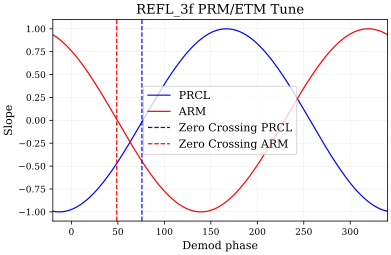

Max slope  [166.33165829]
Stored 'refl_1f_PRM' (ndarray)
Max slope  [320.10050251]
Stored 'refl_1f_PRM' (ndarray)
index no. of zeros [ 53 153]
First Zero crossing 75.87939698492463
index no. of zeros [ 38 137]
First Zero crossing 48.743718592964825


In [82]:
plt.plot(tune, np.array(slope_REFL_1f),label="PRCL")
plt.plot(tune, np.array(slope_arm_REFL_1f),label="ARM ")
plt.xlabel('Demod phase')
plt.ylabel('Slope')
plt.axvline(x=tune[zero_crossings[0]],color='b', linestyle='--',label="Zero Crossing PRCL")
plt.axvline(x=tune[zero_crossings1[0]],color='r', linestyle='--',label="Zero Crossing ARM")
#plt.xlim(-15,15)
plt.title("REFL_3f PRM/ETM Tune")
#plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.legend()
plt.show()

refl_1f_PRM, _ = find_peaks(slope_REFL_1f, height=0)
print("Max slope ", tune[refl_1f_PRM])
%store refl_1f_PRM

refl_1f_ETM, _ = find_peaks(slope_arm_REFL_1f, height=0)
print("Max slope ", tune[refl_1f_ETM])
%store refl_1f_PRM

print('index no. of zeros',zero_crossings)
print('First Zero crossing',tune[zero_crossings[0]])

print('index no. of zeros',zero_crossings1)
print('First Zero crossing',tune[zero_crossings1[0]])

In [83]:
print(slope_arm_REFL_1f[134])

-0.12064212231493796


In [84]:
print(slope_REFL_1f[134])

0.5648590315221427
